In [23]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Compartmental models in epidemiology

In the attempt to understand how we can prevent the spread of COVID19, we now review a simple model and see how we can control the spead of the virus.

In our model, we consider 4 groups of population
1. S - Susceptable, healty people that have no vrus 
2. E - Exposed, people who contracted the virus but are not sick
3. I - Infected, people who were exposed and became sick
4. R - Recovered, those who recovered (or died)

A typical flow is $S \rightarrow E \rightarrow I \rightarrow R$


Let us now consider each of these populations, starting with the susceptable one.

The change in the number of the healthy population in a period of time is negatively proportional to the number of healty people and the number of exposed and sick people. 
$$ {\frac {\delta S}{\delta t}} = - \beta E S - \gamma I S. $$

The parameters $\beta$ and $\gamma$ are determined by the mixing of the populations.
It is easier to control $\gamma$ since we can take better isolation for sick people but the parameter $\beta$ is harder to control.
For close interactions $\beta$ is large and when interactions are limited it is much smaller. We will see the efect of making $\beta$ smaller when we run some simulations.

Next, we consider the exposed population.
The change in the exposed population is positively proportional to the number of healtty individuals. However, since at every period some exposed become sick, the change in exposed is decreasing proportionally to the number of sick people.
This yields
$$ {\frac {\delta E}{\delta t}} = \beta E S + \gamma I S - \alpha E$$

Lastly, we consider the infected people. The rate of change is positively proportional to the number of exposed people and negatively proportial to the number of infected people (as people get healthy or die), yielding
$$ {\frac {\delta I}{\delta t}} = \alpha E - \mu I. $$

Combining these equations and taking the limit as $\delta t \rightarrow 0$ we obtain
\begin{eqnarray}
&& {\frac {d S}{d t}} = - \beta E S - \gamma I S \\
&& {\frac {d E}{d t}} = \beta E S  + \gamma I S - \alpha E \\
&& {\frac {d I}{d t}} = \alpha E - \mu I 
\end{eqnarray}

The equations are equipped with initial conditions on $S, E$ and $I$.
We now see how to model and solve these equations numerically.

In [27]:
# First define the right hand side, we store all the parameters
# in a single vector theta = [alpha, beta,gamma,mu]
def SEImodel(theta,S,E,I):
    alpha = theta[0]
    beta  = theta[1]
    gamma = theta[2]
    mu    = theta[3]
    
    dSdt  = -beta*E*S - gamma*I*S                # dS/dt
    dEdt  = beta*E*S  + gamma*I*S - alpha*E      # dE/dt
    dIdt  = alpha*E - mu*I                       # dI/dt
    
    return dSdt, dEdt, dIdt
    

We now integrate the equation in time using a simple forward Euler

In [28]:
def integrateSEI(theta,S0,E0,I0,dt,nt):
    
    # vectors to save the results over time
    Sout = torch.zeros(nt+1); Sout[0] = S0
    Eout = torch.zeros(nt+1); Eout[0] = E0
    Iout = torch.zeros(nt+1); Iout[0] = I0
    
    S = S0; E = E0; I = I0
    for i in range(nt):
        dSdt, dEdt, dIdt = SEImodel(theta,S,E,I)
        S += dt*dSdt
        E += dt*dEdt
        I += dt*dIdt
        
        Sout[i+1] = S; Eout[i+1] = E; Iout[i+1] = I;
        
    return Sout, Eout, Iout    

maximum of infected people  0.49775537848472595


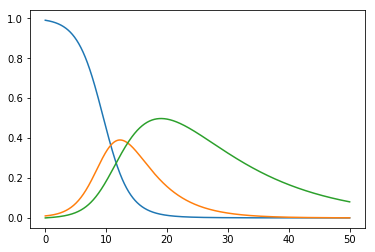

In [29]:
# We start with S0  as 99% of the population
#               E0  1%
#               no sick peaple
S0 = 0.99; E0 = 0.01; I0 = 0.0; 

# Set the duration for the simulation
dt = 0.05; nt = 1000

# We pick the parameters as follows
alpha = 0.2
beta  = 0.5
gamma = 0.5
mu    = 0.075
theta = torch.tensor([alpha, beta, gamma, mu])

S, E, I = integrateSEI(theta,S0,E0,I0,dt,nt)

t = np.arange(nt+1)*dt
plt.plot(t,S,t,E,t,I)

print('maximum of infected people ', torch.max(I).item())

The blue curve is the susceptible population that declines steadily. The orange in the exposed that increased initially and decreased as the number of susceptible population decays and the grean are sick people.
Note that at the peak, 50\% of the population is sick and this can dramatically increase the mortality rate as hospitals collaps.

Our mission is to try and make the peak flatter. We cannot control much. The parameters $\alpha$ and $\mu$ are desease dependant. They relate to how fast an exposed person becomes sick and how fast sick people recover or die. We can on the other hand, control to some extent $\beta$ and $\gamma$. The parameter $\gamma$ decrease as we decrease the interaction between sick people and the rest of the population. It can become very small if we isolate sick people and use highly efficient protactive gear when treating them. The parameter $\beta$ is much more difficult to control. It is the parameter that depend on social interactions.

We now run the code again, reducing $\gamma$ dramatocally, from $0.5$ to $0.01$ and see the reactions

maximum of infected people  0.382425457239151


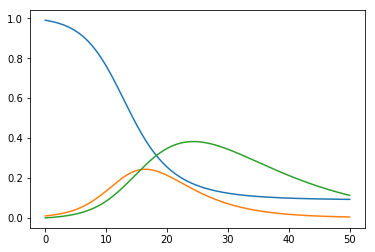

In [30]:
alpha = 0.2
beta  = 0.5
gamma = 0.01
mu    = 0.075
theta = torch.tensor([alpha, beta, gamma, mu])

S, E, I = integrateSEI(theta,S0,E0,I0,dt,nt)

t = np.arange(nt+1)*dt
plt.plot(t,S,t,E,t,I)

print('maximum of infected people ', torch.max(I).item())

By reducing the contact with infected people we managed to "flatten the curve" of infected people to 38\% which is much better than our previous 50\%.
However, having 38\% of the population sick the number is still to high. We would like to reduce this number much more and for that we need to reduce the social interactions, that is, reduce $\beta$. Lets assume that the number of social interaction is reduced to a little bit more than a half. This can be obtained by shutting down schools and public events. 

Since the infection now propages much slower, we use a longer integration period to see the effect.

maximum of infected people  0.17494483292102814


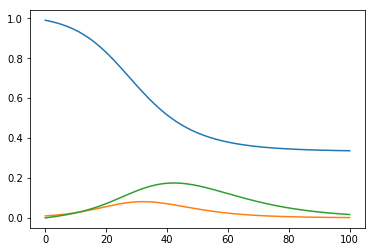

In [31]:
dt = 0.05; nt = 2000

alpha = 0.2
beta  = 0.3
gamma = 0.01
mu    = 0.075
theta = torch.tensor([alpha, beta, gamma, mu])

S, E, I = integrateSEI(theta,S0,E0,I0,dt,nt)

t = np.arange(nt+1)*dt
plt.plot(t,S,t,E,t,I)

print('maximum of infected people ', torch.max(I).item())

Not only that we reduced the size of the peak, we managed to completely stop the infection and indeed 40\% of the population never experienced the desease!

This is why social distancing is so important and why it can help eliminate the desease all together.

# Homework

One of the problems that worry heath scientists is that sick people do not become immune but rather go directly back into the susceptible population. The model for this case is
\begin{eqnarray}
&& {\frac {d S}{d t}} = - \beta E S - \gamma I S + \mu I \\
&& {\frac {d E}{d t}} = \beta E S  + \gamma I S - \alpha E \\
&& {\frac {d I}{d t}} = \alpha E - \mu I 
\end{eqnarray}



1. Use a similar methodology to the one we used above in order to simulate this case.

2. Comparing the previous case how would you change $\beta$ and $\gamma$ to deal with the infection? Can you find a combination of $\beta$ and $\gamma$ that will make the number of sick people smaller than 5\% of the population?
For this part assume that initially $\alpha = 0.2$, $\beta  = 0.3$, $\gamma = 0.01$ and $\mu    = 0.01$.

In [33]:
# First define the right hand side, we store all the parameters
# in a single vector theta = [alpha, beta,gamma,mu]
def SEISmodelS(theta,S,E,I):
    alpha = theta[0]
    beta  = theta[1]
    gamma = theta[2]
    mu    = theta[3]
    
    dSdt  = -beta*E*S - gamma*I*S + mu*I         # dS/dt
    dEdt  = beta*E*S  + gamma*I*S - alpha*E      # dE/dt
    dIdt  = alpha*E - mu*I                       # dI/dt
    
    return dSdt, dEdt, dIdt

def integrateSEIS(theta,S0,E0,I0,dt,nt):
    
    # vectors to save the results over time
    Sout = torch.zeros(nt+1); Sout[0] = S0
    Eout = torch.zeros(nt+1); Eout[0] = E0
    Iout = torch.zeros(nt+1); Iout[0] = I0
    
    S = S0; E = E0; I = I0
    for i in range(nt):
        dSdt, dEdt, dIdt = SEISmodel(theta,S,E,I)
        S += dt*dSdt
        E += dt*dEdt
        I += dt*dIdt
        
        Sout[i+1] = S; Eout[i+1] = E; Iout[i+1] = I;
        
    return Sout, Eout, Iout    